<a href="https://colab.research.google.com/github/thousandoaks/Intro-Causal-Inference/blob/main/code/Effect_of_training_on_real_earnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dowhy

     |████████████████████████████████| 123 kB 5.2 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [41]:
from rpy2.robjects import r as R
%load_ext rpy2.ipython

%R install.packages("Matching")
%R library(Matching)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/Matching_4.9-9.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 298522 bytes (291 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol

'Matching','MASS','tools',...,'datasets','methods','base'


This notebook is an exploration of causal inference in python using the famous Lalonde dataset.


The study looked at the effectiveness of a job training program (the treatment) on the real earnings of an individual, a couple years after completion of the program.

The data consists of a number of demographic variables (age, race, academic background, and previous real earnings), as well as a treatment indicator, and the real earnings in the year 1978 (the response).

Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620

In [2]:
import dowhy
from dowhy import CausalModel

In [10]:
import pandas as pd
import seaborn as sns

In [42]:
%R data(lalonde)
%R -o lalonde
lalonde = lalonde.astype({'treat':'bool'}, copy=False)

In [5]:
lalonde = pd.read_csv('https://raw.githubusercontent.com/mosimann/ADA/master/04%20-%20Applied%20ML/lalonde.csv', index_col=0)
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [43]:
lalonde.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 1 to 445
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      445 non-null    int32  
 1   educ     445 non-null    int32  
 2   black    445 non-null    int32  
 3   hisp     445 non-null    int32  
 4   married  445 non-null    int32  
 5   nodegr   445 non-null    int32  
 6   re74     445 non-null    float64
 7   re75     445 non-null    float64
 8   re78     445 non-null    float64
 9   u74      445 non-null    int32  
 10  u75      445 non-null    int32  
 11  treat    445 non-null    bool   
dtypes: bool(1), float64(3), int32(8)
memory usage: 28.2+ KB


In [21]:
lalonde['treat_boolean']=lalonde['treat'].astype(bool)

In [29]:
lalonde

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,treat_boolean
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,True
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,True
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,True
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,True
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,True
...,...,...,...,...,...,...,...,...,...,...,...
PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000,False
PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100,False
PSID427,0,21,18,0,0,0,0,0.0,0.0,0.0000,False


# Step 0. Exploratory Analysis

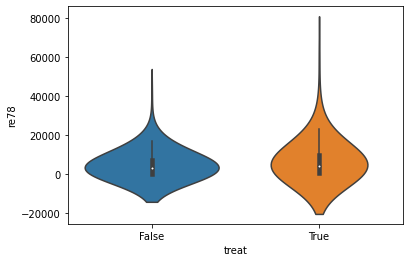

In [78]:
ax = sns.violinplot(data=lalonde[['treat','re78']], x="treat", y="re78",bw=1.3)

From the previous the treatment does not seem to have a significant effect on income

In [74]:
lalonde.groupby(['black','treat'])['re78'].agg(['mean'])

mean
black treat             
0     False  6691.182444
      True   7493.984586
1     False  4107.652947
      True   6136.322692

In [75]:
lalonde.groupby(['married','treat'])['re78'].agg(['mean'])

mean
married treat             
0       False  4646.505186
        True   6019.999273
1       False  4050.436312
        True   7759.771486

In [76]:
lalonde.groupby(['educ','treat'])['re78'].agg(['mean'])

mean
educ treat              
3    False   5843.800000
4    False   3880.830000
     True    5495.511250
5    False      0.000000
     True    8972.000000
6    False   2471.212500
     True       0.000000
7    False   3309.634286
     True    1511.940000
8    False   4623.975238
     True    2769.099444
9    False   5699.545475
     True    6067.168107
10   False   4524.355859
     True    5522.333774
11   False   4091.626479
     True    6755.477591
12   False   4868.967917
     True    6552.871410
13   False   4068.134000
     True    9237.833125
14   False   6559.870000
     True   18656.980000
15   True    9598.540000
16   True    2164.020000

From the previous we observe that some collectives were not exposed to non-treatment, for instance those with years of education 15 and 16.

## The issue is that the dataset is not a balanced trial. Indeed people in the control group are very different from people in the test (treatment) group. 

Aims. What we want to know here is the Average Treatment Effect (ATE):
Δ=E[Y1−Y0]

# General problem. 

The confounding variables (age, education, race, etc) affect both the treatment and the outcome.

Ideally this is addressed via randomized controlled trials. 

In this case the exposure to treatment is not random. We need to resort to causal modelling techniques.




# Step 1. Causal Model specification

In [52]:
model=CausalModel(
        data = lalonde,
        treatment='treat',
        outcome='re78',
        common_causes='nodegr+black+hisp+age+educ+married'.split('+'))

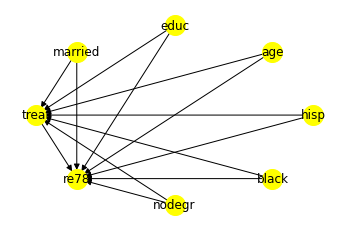

In [53]:
model.view_model()

# Step 2.Identify

In [54]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Step 3.Estimate

In [80]:
estimate1 = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        method_params={"weighting_scheme":"ips_weight"})
#print(estimate)
print("Causal Estimate is " + str(estimate1.value))

Causal Estimate is 1614.166482916211


In [56]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching"
)

print("Causal Estimate is " + str(estimate.value))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Causal Estimate is 2196.6096595505614


In [79]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification", method_params={'num_strata':20, 'clipping_threshold':5})

print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 1828.088663418079


# Step 4. Refute

In [60]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
refute_results=model.refute_estimate(identified_estimand, estimate1,
        method_name="random_common_cause")
print(refute_results)


Refute: Add a Random Common Cause
Estimated effect:1614.166482916211
New effect:1594.921603028657



In [82]:
res_placebo=model.refute_estimate(identified_estimand, estimate1,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:1614.166482916211
New effect:92.5011508564639
p value:0.47



In [83]:
res_subset=model.refute_estimate(identified_estimand, estimate1,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:1614.166482916211
New effect:1606.020021899477
p value:0.49

